In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
class Static_Threshold:
    def __init__(self, build_threshold, liquidate_threshold):
        self.build_threshold = build_threshold
        self.liquidate_threshold = liquidate_threshold
        self.position = 0

    def generate_positions(self, df):
        for i in range(1, len(df)):
            alpha_prev = df.loc[i-1, 'alpha']
            alpha_curr = df.loc[i, 'alpha']

            if self.position == 0:
                if alpha_curr >= self.build_threshold and alpha_prev < self.build_threshold:
                    self.position = 1
                elif alpha_curr <= -self.build_threshold and alpha_prev > -self.build_threshold:
                    self.position = -1
                    
            elif self.position == 1:
                if alpha_curr <= self.liquidate_threshold and alpha_prev > self.liquidate_threshold:
                    self.position = 0

            elif self.position == -1:
                if alpha_curr >= -self.liquidate_threshold and alpha_prev < -self.liquidate_threshold:
                    self.position = 0

            df.loc[i, 'position'] = self.position
        
        return df
    

class Backtest:
    def __init__(self, df):
        self.df = df

    def backtest(self):
        pnl = [0]
        curr_pnl = 0

        for i in range(1, len(self.df)):
            
            curr_pnl += self.df.loc[i, 'position'] * (self.df.loc[i, 'price'] - self.df.loc[i-1, 'price'])
            pnl.append(curr_pnl)

        self.df['pnl'] = pnl    

        return self.df, curr_pnl
    
    def plot(self):
        plt.plot(self.df['serial_num'], self.df['pnl'], color='blue', label='PnL')
        plt.xlabel('Time')
        plt.ylabel('PnL')
        plt.legend()
        plt.grid(True)
        plt.show()

    

class optimizer:
    def __init__(self, df, BT_lb, BT_ub, LT_lb, LT_ub, step_size):
        self.df = df
        self.BT_lb = BT_lb
        self.BT_ub = BT_ub
        self.LT_lb = LT_lb
        self.LT_ub = LT_ub
        self.step_size = step_size

    def optimize(self):
        max_pnl = [0]
        best_build_threshold = [0]
        best_liquidate_threshold = [0]

        for build_threshold in np.arange(self.BT_lb, self.BT_ub, self.step_size):
            for liquidate_threshold in np.arange(self.LT_lb, self.LT_ub, self.step_size):
                st = Static_Threshold(build_threshold, liquidate_threshold)
                df = st.generate_positions(self.df)
                bt = Backtest(df)
                df, pnl = bt.backtest()

                if pnl > max_pnl[-1]:
                    max_pnl.append(pnl)
                    best_build_threshold.append(build_threshold)
                    best_liquidate_threshold.append(liquidate_threshold)

        return pd.DataFrame({'max_pnl': max_pnl, 'best_build_threshold': best_build_threshold, 'best_liquidate_threshold': best_liquidate_threshold})



Final PnL: 18814.00402904659


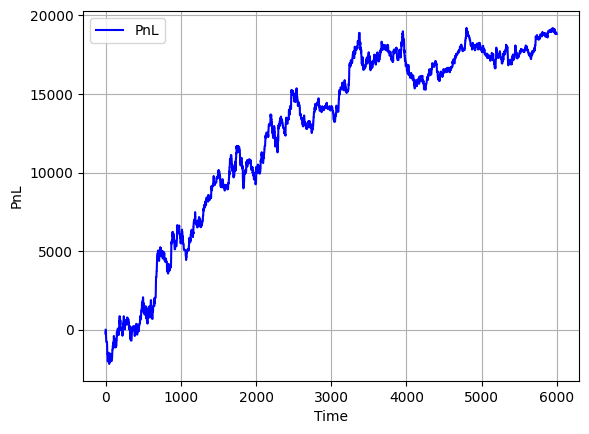

In [8]:
df = pd.read_csv('asset_1.csv')

Build_threshold = 0.51
Liquidate_threshold = 0.01

strategy = Static_Threshold(Build_threshold, Liquidate_threshold)
df_update = strategy.generate_positions(df)

engine = Backtest(df_update)
df_final, pnl = engine.backtest()

print('Final PnL:', pnl)
engine.plot()

In [9]:
BT_LB = 0.5
BT_UB = 1
LT_LB = 0.5
LT_UB = 1
step_size = 0.05

opt = optimizer(df, BT_LB, BT_UB, LT_LB, LT_UB, step_size)
pnl_df = opt.optimize()

In [10]:
pnl_df

,max_pnl,best_build_threshold,best_liquidate_threshold
0,0.000000,0.0,0.0
1,12544.983273,0.5,0.5
